Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
print('Using L2 Regularization for Logistic Model')
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf_l2_feature * tf.nn.l2_loss(weights)

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

print('Tensorflow Graph created')

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Using L2 Regularization for Logistic Model
Tensorflow Graph created
Initialized
Minibatch loss at step 0: 24.617813
Minibatch accuracy: 7.0%
Validation accuracy: 6.0%
Minibatch loss at step 500: 2.330762
Minibatch accuracy: 80.5%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 1.741897
Minibatch accuracy: 79.7%
Validation accuracy: 78.1%
Minibatch loss at step 1500: 1.030663
Minibatch accuracy: 82.8%
Validation accuracy: 79.8%
Minibatch loss at step 2000: 0.815896
Minibatch accuracy: 88.3%
Validation accuracy: 80.7%
Minibatch loss at step 2500: 0.812145
Minibatch accuracy: 80.5%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.782411
Minibatch accuracy: 82.8%
Validation accuracy: 81.7%
Test accuracy: 88.8%


In [6]:
print('Tunning the L2 Regularization constant')

num_steps = 3001
l2_constant_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []
max_accuracy, best_l2_constant = 0, 0

for l2_constant in l2_constant_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: l2_constant}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        if test_accuracy == max(max_accuracy, test_accuracy):
            max_accuracy = test_accuracy
            best_l2_constant = l2_constant
        accuracy_values.append(test_accuracy)
        print('L2 Regularization constant of %f performed with %.2f%% accuracy' % (l2_constant, accuracy_values[-1]))

Tunning the L2 Regularization constant
L2 Regularization constant of 0.000100 performed with 86.90% accuracy
L2 Regularization constant of 0.000126 performed with 86.60% accuracy
L2 Regularization constant of 0.000158 performed with 87.20% accuracy
L2 Regularization constant of 0.000200 performed with 87.41% accuracy
L2 Regularization constant of 0.000251 performed with 87.36% accuracy
L2 Regularization constant of 0.000316 performed with 87.69% accuracy
L2 Regularization constant of 0.000398 performed with 88.31% accuracy
L2 Regularization constant of 0.000501 performed with 88.34% accuracy
L2 Regularization constant of 0.000631 performed with 88.55% accuracy
L2 Regularization constant of 0.000794 performed with 88.71% accuracy
L2 Regularization constant of 0.001000 performed with 88.97% accuracy
L2 Regularization constant of 0.001259 performed with 88.93% accuracy
L2 Regularization constant of 0.001585 performed with 89.14% accuracy
L2 Regularization constant of 0.001995 performed wi

Plot the L2 Regularization loss for our Test


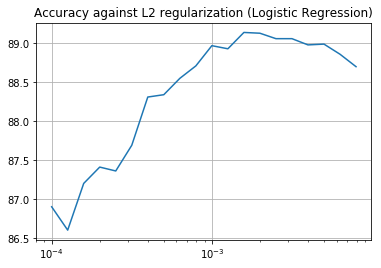

Maximum accuracy is 89.14% with L2 Regularization constant of 0.001585


In [7]:
print('Plot the L2 Regularization loss for our Test')
plt.semilogx(l2_constant_values, accuracy_values)
plt.grid(True)
plt.title('Accuracy against L2 regularization (Logistic Regression)')
plt.show()
print('Maximum accuracy is %.2f%% with L2 Regularization constant of %f' % (max_accuracy, best_l2_constant))

In [8]:
print('Using L2 Regularization for Neural Network Model (1 Layer)')
batch_size = 128
num_hidden_nodes = 1024

# Buildig the Network
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)

    # Variables.
    layer1_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    layer1_biases = tf.Variable(tf.zeros([num_hidden_nodes]))
    layer2_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    layer2_biases = tf.Variable(tf.zeros([num_labels]))    

    # Training computation.
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, layer1_weights) + layer1_biases)
    logits = tf.matmul(hidden_layer, layer2_weights) + layer2_biases
    loss = tf.reduce_mean( \
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    tf_l2_feature * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden_layer_valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, layer1_weights) + layer1_biases)
    valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_layer_valid_prediction, layer2_weights) + layer2_biases)
    hidden_layer_test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, layer1_weights) + layer1_biases)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_layer_test_prediction, layer2_weights) + layer2_biases)

print('Tensorflow Graph created')

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Using L2 Regularization for Neural Network Model (1 Layer)
Tensorflow Graph created
Initialized
Minibatch loss at step 0: 600.963013
Minibatch accuracy: 12.5%
Validation accuracy: 20.0%
Minibatch loss at step 500: 201.086609
Minibatch accuracy: 78.9%
Validation accuracy: 77.9%
Minibatch loss at step 1000: 115.457634
Minibatch accuracy: 78.9%
Validation accuracy: 81.9%
Minibatch loss at step 1500: 68.334595
Minibatch accuracy: 89.1%
Validation accuracy: 82.8%
Minibatch loss at step 2000: 41.258797
Minibatch accuracy: 90.6%
Validation accuracy: 84.8%
Minibatch loss at step 2500: 25.166409
Minibatch accuracy: 89.8%
Validation accuracy: 85.4%
Minibatch loss at step 3000: 15.486179
Minibatch accuracy: 85.9%
Validation accuracy: 86.1%
Test accuracy: 92.8%


In [12]:
print('Tunning the L2 Regularization constant')

num_steps = 3001
l2_constant_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []
max_accuracy, best_l2_constant = 0, 0

for l2_constant in l2_constant_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: l2_constant}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        if test_accuracy == max(accuracy_values, test_accuracy):
            max_accuracy = test_accuracy
            best_ls_constact = l2_constant
        accuracy_values.append(test_accuracy)
    print('Accuracy of %.2f%% for L2 parameter constant of %f' % (accuracy_values[-1], l2_constant))

Tunning the L2 Regularization constant
Accuracy of 89.71% for L2 parameter constant of 0.000100
Accuracy of 89.42% for L2 parameter constant of 0.000126
Accuracy of 89.43% for L2 parameter constant of 0.000158
Accuracy of 90.34% for L2 parameter constant of 0.000200
Accuracy of 90.70% for L2 parameter constant of 0.000251
Accuracy of 90.78% for L2 parameter constant of 0.000316
Accuracy of 90.94% for L2 parameter constant of 0.000398
Accuracy of 91.20% for L2 parameter constant of 0.000501
Accuracy of 92.10% for L2 parameter constant of 0.000631
Accuracy of 92.58% for L2 parameter constant of 0.000794
Accuracy of 93.20% for L2 parameter constant of 0.001000
Accuracy of 93.22% for L2 parameter constant of 0.001259
Accuracy of 93.27% for L2 parameter constant of 0.001585
Accuracy of 92.98% for L2 parameter constant of 0.001995
Accuracy of 92.63% for L2 parameter constant of 0.002512
Accuracy of 92.40% for L2 parameter constant of 0.003162
Accuracy of 92.09% for L2 parameter constant of 0

Plot the L2 Regularization loss for our Test


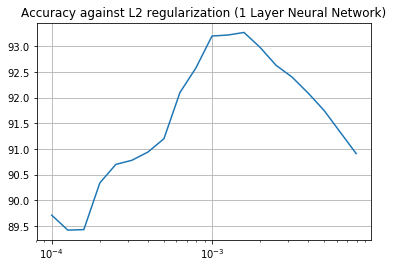

Maximum accuracy is 0.00% with L2 Regularization constant of 0.000000


In [14]:
print('Plot the L2 Regularization loss for our Test')
plt.semilogx(l2_constant_values, accuracy_values)
plt.grid(True)
plt.title('Accuracy against L2 regularization (1 Layer Neural Network)')
plt.show()
print('Maximum accuracy is %.2f%% with L2 Regularization constant of %f' % (max_accuracy, best_l2_constant))

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [18]:
print('Using L2 Regularization for Neural Network Model (1 Layer) with overfitting')
batch_size = 128
num_hidden_nodes = 1024

# Buildig the Network
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)

    # Variables.
    layer1_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    layer1_biases = tf.Variable(tf.zeros([num_hidden_nodes]))
    layer2_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    layer2_biases = tf.Variable(tf.zeros([num_labels]))    

    # Training computation.
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, layer1_weights) + layer1_biases)
    logits = tf.matmul(hidden_layer, layer2_weights) + layer2_biases
    loss = tf.reduce_mean( \
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    tf_l2_feature * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden_layer_valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, layer1_weights) + layer1_biases)
    valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_layer_valid_prediction, layer2_weights) + layer2_biases)
    hidden_layer_test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, layer1_weights) + layer1_biases)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_layer_test_prediction, layer2_weights) + layer2_biases)

print('Tensorflow Graph created')

num_steps = 101

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: best_l2_constant}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Using L2 Regularization for Neural Network Model (1 Layer) with overfitting
Tensorflow Graph created
Initialized
Minibatch loss at step 0: 331.357239
Minibatch accuracy: 12.5%
Validation accuracy: 24.1%
Minibatch loss at step 1: 1060.645874
Minibatch accuracy: 23.4%
Validation accuracy: 37.0%
Minibatch loss at step 2: 1377.602539
Minibatch accuracy: 44.5%
Validation accuracy: 39.9%
Minibatch loss at step 3: 1212.494019
Minibatch accuracy: 28.1%
Validation accuracy: 40.2%
Minibatch loss at step 4: 431.445068
Minibatch accuracy: 37.5%
Validation accuracy: 58.1%
Minibatch loss at step 5: 289.389648
Minibatch accuracy: 57.0%
Validation accuracy: 60.5%
Minibatch loss at step 6: 255.189468
Minibatch accuracy: 55.5%
Validation accuracy: 71.6%
Minibatch loss at step 7: 111.873390
Minibatch accuracy: 70.3%
Validation accuracy: 73.0%
Minibatch loss at step 8: 98.487244
Minibatch accuracy: 72.7%
Validation accuracy: 71.9%
Minibatch loss at step 9: 66.364189
Minibatch accuracy: 74.2%
Validation ac

Validation accuracy: 78.3%
Minibatch loss at step 90: 22.866604
Minibatch accuracy: 82.8%
Validation accuracy: 78.7%
Minibatch loss at step 91: 15.765753
Minibatch accuracy: 82.8%
Validation accuracy: 78.7%
Minibatch loss at step 92: 46.764633
Minibatch accuracy: 75.8%
Validation accuracy: 77.1%
Minibatch loss at step 93: 39.775341
Minibatch accuracy: 79.7%
Validation accuracy: 74.5%
Minibatch loss at step 94: 68.661163
Minibatch accuracy: 67.2%
Validation accuracy: 74.5%
Minibatch loss at step 95: 42.960827
Minibatch accuracy: 80.5%
Validation accuracy: 76.0%
Minibatch loss at step 96: 39.657455
Minibatch accuracy: 71.9%
Validation accuracy: 76.8%
Minibatch loss at step 97: 61.205605
Minibatch accuracy: 77.3%
Validation accuracy: 76.8%
Minibatch loss at step 98: 36.469139
Minibatch accuracy: 75.8%
Validation accuracy: 77.2%
Minibatch loss at step 99: 41.573650
Minibatch accuracy: 74.2%
Validation accuracy: 74.9%
Minibatch loss at step 100: 41.579025
Minibatch accuracy: 74.2%
Validatio

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [ ]:
print('Using L2 Regularization for Neural Network Model (1 Layer) with Dropout')
batch_size = 128
num_hidden_nodes = 1024

# Buildig the Network
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_feature = tf.placeholder(tf.float32)

    # Variables.
    layer1_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    layer1_biases = tf.Variable(tf.zeros([num_hidden_nodes]))
    layer2_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    layer2_biases = tf.Variable(tf.zeros([num_labels]))    

    # Training computation.
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, layer1_weights) + layer1_biases)
    hidden_layer_with_dropout = tf.nn.dropout(hidden_layer)
    logits = tf.matmul(hidden_layer_with_dropout, layer2_weights) + layer2_biases
    loss = tf.reduce_mean( \
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    tf_l2_feature * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden_layer_valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, layer1_weights) + layer1_biases)
    valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_layer_valid_prediction, layer2_weights) + layer2_biases)
    hidden_layer_test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, layer1_weights) + layer1_biases)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_layer_test_prediction, layer2_weights) + layer2_biases)

print('Tensorflow Graph created')

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_feature: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
